In [1]:
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse 

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, datasets, models
# from efficientnet_pytorch import EfficientNet 
import copy
import tqdm
from PIL import Image
from torchsummary import summary
%matplotlib inline

In [5]:
data_dir = '/content/drive/My Drive/case_study/output_data/train_10'
val_dir = '/content/drive/My Drive/case_study/output_data/validation_10'
test_dir = '/content/drive/My Drive/case_study/output_data/test_10'
list_labels = []
list_amount = []
for label in os.listdir(data_dir):
  list_labels.append(label)
  list_amount.append(len(os.listdir(os.path.join(data_dir, label))))
print(list_labels)
print(list_amount)
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
# mean_nums = torch.tensor(0.8797)
# std_nums = torch.tensor(0.2144)

def load_split_train_test(datadir, val_dir, test_dir):
    train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.RandomRotation(degrees=5),
                                        # transforms.ColorJitter(),
                                        # transforms.RandomHorizontalFlip(),
                                        # transforms.RandomVerticalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean_nums, std_nums)
                                       ])
    val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                        # transforms.RandomRotation(degrees=7),
                                        # transforms.ColorJitter(),
                                        # transforms.RandomHorizontalFlip(),
                                        # transforms.RandomVerticalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean_nums, std_nums)
                                      ])
    
    test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean_nums, std_nums)
                                      ])

    train_data = datasets.ImageFolder(data_dir,       
                    transform=train_transforms)
    
    val_data = datasets.ImageFolder(val_dir,
                    transform=val_transforms)
    
    test_data = datasets.ImageFolder(test_dir,
                    transform=val_transforms)
    
    num_train = len(train_data)
    num_val = len(val_data)
    num_test = len(test_data)
  
    
    # valid_count = int(split_ratio * num_train)
    # train_count =  num_train - valid_count
    print(num_train)
    print(num_val)
    print(num_test)

    trainloader = torch.utils.data.DataLoader(train_data,
                  batch_size=128, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_data,
                  batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(test_data,
                  batch_size=128, shuffle=True, num_workers=2)
    
    return trainloader, valloader, testloader
  
trainloader, valloader ,testloader = load_split_train_test(data_dir, val_dir, test_dir)

# print(dir(trainloader.dataset))
print(trainloader.dataset.classes)
classes = trainloader.dataset.classes
len(trainloader.dataset.classes)


['rupicapra', 'mouflon', 'sheep', 'goat']
[566, 437, 503, 494]
2000
435
280
['goat', 'mouflon', 'rupicapra', 'sheep']


4

In [6]:
image, label = next(iter(trainloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


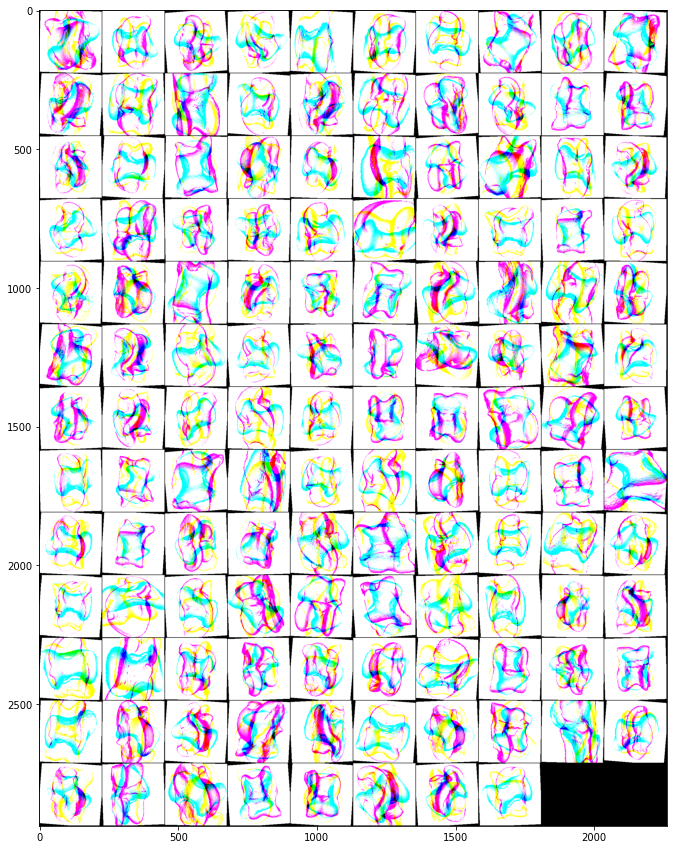

In [7]:
grid = torchvision.utils.make_grid(image, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

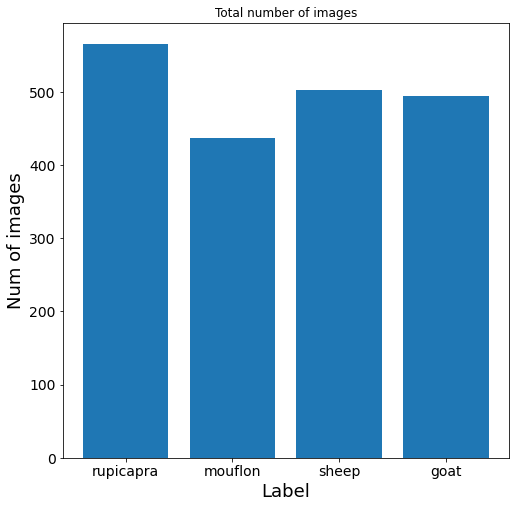

In [8]:
fig, ax = plt.subplots(figsize=(8,8)) 
labels = list_labels 
amount = list_amount 
# create bar chart 
ax.bar(labels, amount) 
# set title and labels 
ax.set_title('Total number of images') 
ax.set_xlabel('Label', fontsize = 18) 
ax.set_ylabel('Num of images', fontsize = 18)
ax.tick_params(labelsize=14)


In [9]:
device = torch.device("cuda")
model = models.resnet18(pretrained=True)
# model = EfficientNet.from_pretrained('efficientnet-b0')
print(model)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 



> Indented block



In [10]:
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(128, 64),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(64, 4),
                                 nn.LogSoftmax(dim=1))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-9, weight_decay=0.001)
model.to(device)
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [11]:
epochs = 300
steps = 0
correct = 0
running_loss = 0
print_every = 16
train_losses, test_losses, train_accuracies,test_accuracies = [], [],[], []
for epoch in range(epochs):
    if epoch == 100:
      optimizer = optim.Adam(model.fc.parameters(), lr=0.0001, weight_decay=0.003)
    if epoch == 175:
      optimizer = optim.Adam(model.fc.parameters(), lr=0.00005, betas=(0.9, 0.99), weight_decay=0.004)
    stop = False
    for inputs, labels in trainloader:
      steps += 1
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      logps = model.forward(inputs)
      loss = criterion(logps, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _, predicted = torch.max(logps, 1)
      correct += torch.mean((predicted == labels).float())
      if steps % print_every == 0:
          test_loss = 0
          accuracy = 0
          model.eval()
          with torch.no_grad():
              for inputs, labels in valloader:
                  inputs, labels = inputs.to(device),labels.to(device)
                  logps = model.forward(inputs)
                  batch_loss = criterion(logps, labels)
                  test_loss += batch_loss.item()

                  ps = torch.exp(logps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          train_accuracies.append(correct/print_every)
          train_losses.append(running_loss/print_every)
          test_losses.append(test_loss/len(valloader))
          if(test_loss/len(valloader) < 0.02):
              stop = True
              break;
          test_accuracies.append(accuracy/len(valloader))                    
          print(f"Epoch {epoch+1}/{epochs}.. " 
                f"Train loss: {running_loss/print_every :.3f}.. "
                f"Test loss: {test_loss/len(valloader):.3f}.. "
                f"Train accuracy: {correct/print_every:.3f}.. "
                f"Test accuracy: {accuracy/len(valloader):.3f}")
          correct = 0
          running_loss = 0
      model.train()

torch.save(model.state_dict(), '/content/drive/My Drive/case_study/dermmodel112.pth')


Epoch 1/300.. Train loss: 1.391.. Test loss: 1.376.. Train accuracy: 0.262.. Test accuracy: 0.289
Epoch 2/300.. Train loss: 1.387.. Test loss: 1.384.. Train accuracy: 0.267.. Test accuracy: 0.215
Epoch 3/300.. Train loss: 1.383.. Test loss: 1.380.. Train accuracy: 0.276.. Test accuracy: 0.338
Epoch 4/300.. Train loss: 1.378.. Test loss: 1.372.. Train accuracy: 0.277.. Test accuracy: 0.225
Epoch 5/300.. Train loss: 1.375.. Test loss: 1.377.. Train accuracy: 0.288.. Test accuracy: 0.220
Epoch 6/300.. Train loss: 1.362.. Test loss: 1.347.. Train accuracy: 0.310.. Test accuracy: 0.335
Epoch 7/300.. Train loss: 1.336.. Test loss: 1.340.. Train accuracy: 0.342.. Test accuracy: 0.364
Epoch 8/300.. Train loss: 1.301.. Test loss: 1.300.. Train accuracy: 0.360.. Test accuracy: 0.367
Epoch 9/300.. Train loss: 1.263.. Test loss: 1.309.. Train accuracy: 0.383.. Test accuracy: 0.331
Epoch 10/300.. Train loss: 1.236.. Test loss: 1.362.. Train accuracy: 0.433.. Test accuracy: 0.380
Epoch 11/300.. Trai

## Validation Model

#### Print training history of model

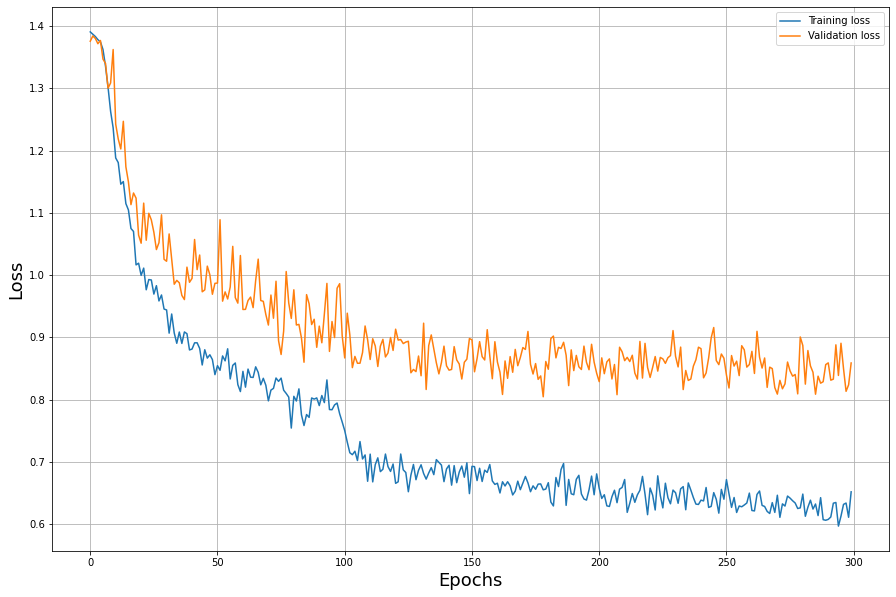

In [12]:
plt.figure(figsize=(15,10))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=True)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.grid(True)
plt.show()

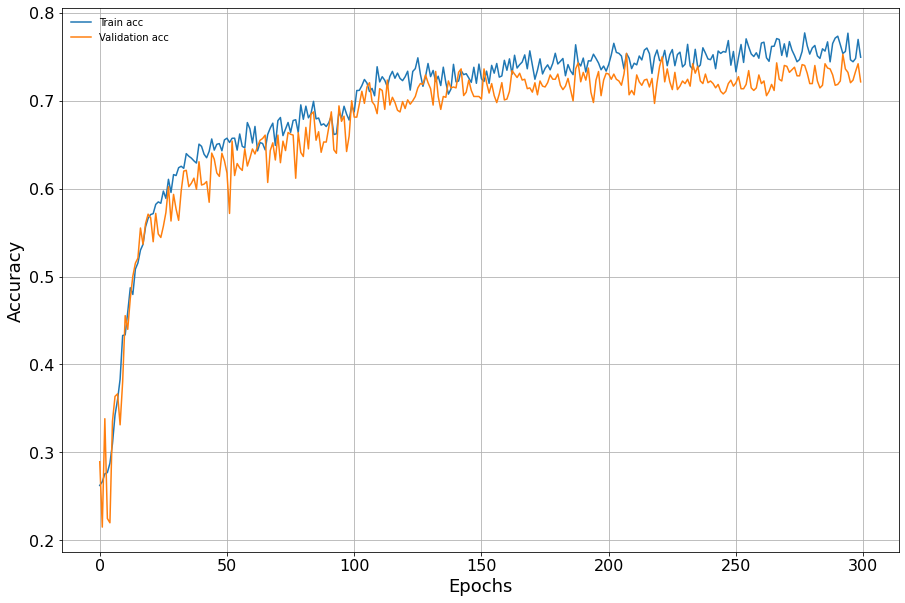

In [13]:
plt.figure(figsize=(15,10))
plt.plot(train_accuracies, label='Train acc')
plt.plot(test_accuracies, label='Validation acc')
plt.legend(frameon=False)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.grid(True)
plt.show()

#### Classification report and Confusion matrix


In [14]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, accuracy_score, classification_report

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, testloader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))


print(classification_report(actuals, predictions, target_names=classes))

Confusion matrix:
[[30  2 13 15]
 [ 5 22 14 16]
 [ 2  0 62 16]
 [ 3  5 22 53]]
F1 score: 0.596429
Accuracy score: 0.596429
              precision    recall  f1-score   support

        goat       0.75      0.50      0.60        60
     mouflon       0.76      0.39      0.51        57
   rupicapra       0.56      0.78      0.65        80
       sheep       0.53      0.64      0.58        83

    accuracy                           0.60       280
   macro avg       0.65      0.57      0.59       280
weighted avg       0.63      0.60      0.59       280



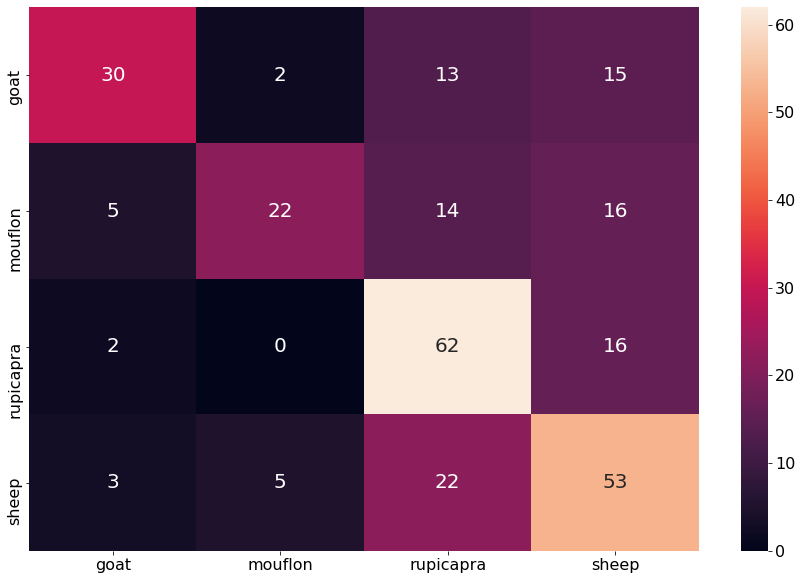

In [15]:
import seaborn as sn

confusion_mat = confusion_matrix(actuals, predictions)
df_cm = pd.DataFrame(confusion_mat, index = [i for i in classes],
                  columns = [i for i in classes])

plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20})

In [16]:
actuals, predictions = test_label_predictions(model, device, trainloader)
print('Confusion matrix on train dataset:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))


print(classification_report(actuals, predictions, target_names=classes))

Confusion matrix on train dataset:
[[467   1  16  10]
 [  5 352  48  32]
 [ 15  37 481  33]
 [ 13  23  48 419]]
F1 score: 0.859500
Accuracy score: 0.859500
              precision    recall  f1-score   support

        goat       0.93      0.95      0.94       494
     mouflon       0.85      0.81      0.83       437
   rupicapra       0.81      0.85      0.83       566
       sheep       0.85      0.83      0.84       503

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [17]:
actuals, predictions = test_label_predictions(model, device, valloader)
print('Confusion matrix on validation dataset:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))


print(classification_report(actuals, predictions, target_names=classes))

Confusion matrix on validation dataset:
[[104   3  14  16]
 [  4  53  14  13]
 [  5   0  75  15]
 [  4   8  24  83]]
F1 score: 0.724138
Accuracy score: 0.724138
              precision    recall  f1-score   support

        goat       0.89      0.76      0.82       137
     mouflon       0.83      0.63      0.72        84
   rupicapra       0.59      0.79      0.68        95
       sheep       0.65      0.70      0.67       119

    accuracy                           0.72       435
   macro avg       0.74      0.72      0.72       435
weighted avg       0.75      0.72      0.73       435



In [18]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output.cpu()[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]


{0: 0.8929113800029392, 1: 0.9124609957943292, 2: 0.8902786377708979, 3: 0.8634719710669079}


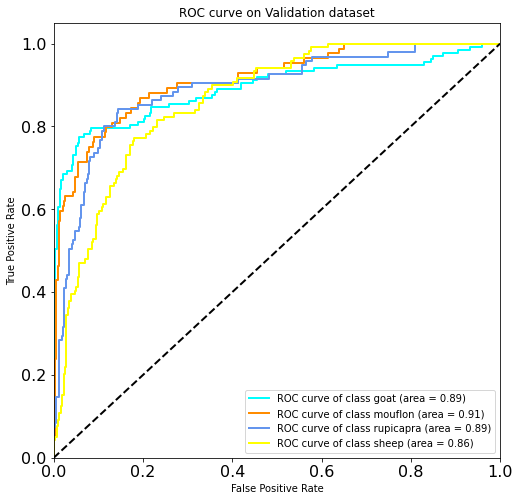

In [19]:
from sklearn.metrics import roc_curve, auc, classification_report
from itertools import cycle

plt.figure(figsize = (8, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow'])


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):

    actuals, class_probabilities = test_class_probabilities(model, device, valloader, i)

    fpr[i], tpr[i], _ = roc_curve(actuals, class_probabilities)
    
    roc_auc[i] = auc(fpr[i], tpr[i])

from itertools import cycle

print(roc_auc)
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on Validation dataset')
plt.legend(loc="lower right")
plt.show()



{0: 0.7781060606060607, 1: 0.8451734717960822, 2: 0.8310625, 3: 0.7509632438382973}


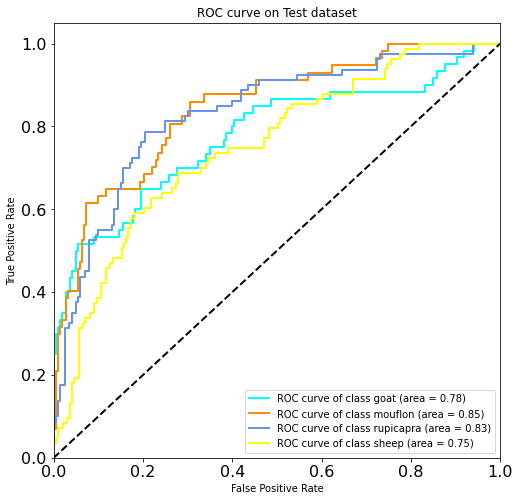

In [20]:
from sklearn.metrics import roc_curve, auc, classification_report
from itertools import cycle

plt.figure(figsize = (8, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow'])


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):

    actuals, class_probabilities = test_class_probabilities(model, device, testloader, i)

    fpr[i], tpr[i], _ = roc_curve(actuals, class_probabilities)
    
    roc_auc[i] = auc(fpr[i], tpr[i])

from itertools import cycle

print(roc_auc)
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on Test dataset')
plt.legend(loc="lower right")
plt.show()



# New Section

In [22]:
from torch.autograd import Variable
test_dir = '/content/drive/My Drive/case_study/output_data/test_10'
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean_nums, std_nums)
                                      ])
# load_transforms = transforms.Compose([transforms.Resize((224,224)),
#                                        transforms.ToTensor(),
#                                       #  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#                                        ])
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [39]:
def get_random_images(num):
    data = datasets.ImageFolder(val_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, loader

In [40]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

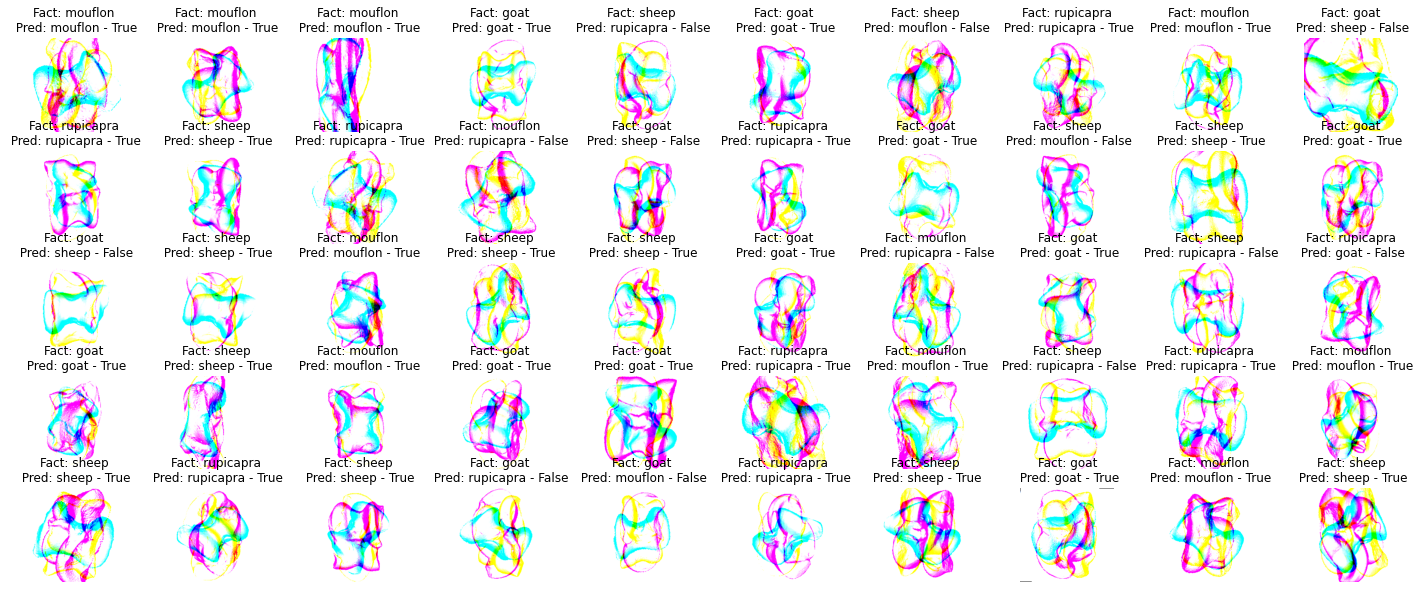

In [56]:
len_list_test = 50
true_count = 0
images, labels, loader = get_random_images(len_list_test)

prediction = []
for inputs, labels in loader:
      steps += 1
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      logps = model.forward(inputs)
      loss = criterion(logps, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _, predicted = torch.max(logps, 1)
      prediction = predicted.tolist()

fig=plt.figure(figsize=(25,10))
for ii in range(len(images)):
    image = images[ii]
    sub = fig.add_subplot(5, 10, ii+1)
    res = int(labels[ii]) == prediction[ii]
    if int(labels[ii]) == prediction[ii]:
      true_count += 1
    sub.set_title(("Fact: " + str(classes[int(labels[ii])]) + "\n Pred: " + str(classes[prediction[ii]]) + " - " + str(res)))
    plt.axis('off')
    plt.imshow(images[ii].permute(1, 2, 0))
plt.show()

In [57]:
print(true_count)

37


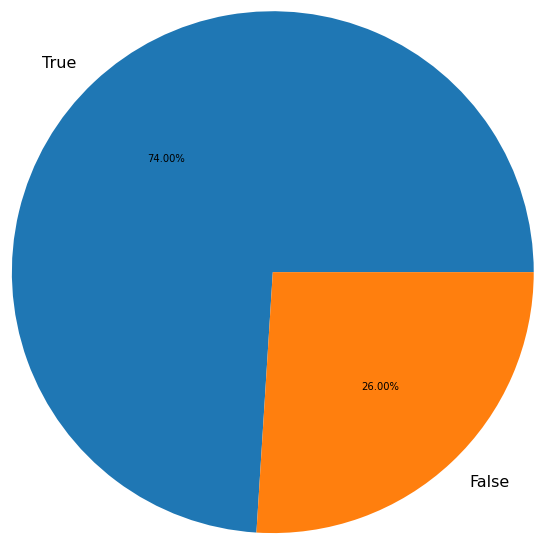

In [58]:
import matplotlib.pyplot as plt
plt.figure()
values = [true_count / 50, (50 - true_count) / 50] 
labels = ['True', 'False'] 
plt.pie(values, labels=labels, autopct='%.2f%%', radius=3.0)
plt.show()